# Web Data Scraping

[Spring 2023 ITSS Mini-Course](https://www.colorado.edu/cartss/programs/interdisciplinary-training-social-sciences-itss/mini-course-web-data-scraping) — ARSC 5040  
[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

These notebooks are adaptations from a 5 session mini course at the University of Colorado. The github repo can be found here [Spring 2023 ITSS Mini-Course] The course is taught by Brian C. Keegan, Ph.D. Assistant Professor, Department of Information Science. They have been adapted for relevant content and integration with Docker so that we all have the same environment. Professor Keegan suggests using a most recent version of Python which we have through our docker container.

This notebook is adapted from excellent notebooks in Dr. Cody Buntain's seminar on Social Media and Crisis Informatics as well as the PRAW documentation.

We'll need a few common libraries for all these examples.

In [9]:
# Lets us talk to other servers on the web
import requests

# APIs spit out data in JSON
import json

# Use BeautifulSoup to parse some HTML
from bs4 import BeautifulSoup

# Safetly quoting strings for URLs
from urllib.parse import unquote, quote

# Handling dates and times
from datetime import datetime

# DataFrames!
import pandas as pd
import numpy as np

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Scraping the Internet Archive's Wayback Machine

Now we'll leave some of the ethically-fraught methods of web scraping behind. The Internet Archive maintains the "[Wayback Machine](https://www.archive.org/web/)" where old versions of websites are stored. Some of my favorites:

* [CNN in June 2000](https://web.archive.org/web/20000815052826/http://www.cnn.com/)
* [Facebook in August 2004](https://web.archive.org/web/20040817020419/http://www.facebook.com/)
* [Apple in April 1997](https://web.archive.org/web/19970404064444/http://www.apple.com:80/)

In these URLs above, there is a numeric identifier corresponding to the timestamp when the image of the website was captured. How do we know when the Wayback Machine archived a webpage? There's a free and open API!

### Using the Wayback Machine API

The simplest API request we can make asks for the most recent snapshot of a webpage archived by the Wayback Machine.

In [10]:
wb_url = 'http://archive.org/wayback/available?url=facebook.com'

wb_response = requests.get(wb_url)

wb_response.json()

{'url': 'facebook.com', 'archived_snapshots': {}}

This response tells us the timestamp and location of this snapshot, which we could then go retrieve and parse.

In [11]:
wb_response_json = wb_response.json()

recent_fb_wb_url = wb_response_json['archived_snapshots']['closest']['url']

recent_fb_wb_response = requests.get(recent_fb_wb_url)

KeyError: 'closest'

Get the raw text out, soupify, and look for links. For some reason all the links in this snapshot are in German.

In [12]:
recent_fb_wb_raw = recent_fb_wb_response.text

recent_fb_wb_soup = BeautifulSoup(recent_fb_wb_raw)

[link.text for link in recent_fb_wb_soup.find_all('a')]

NameError: name 'recent_fb_wb_response' is not defined

We can also ask for the most recent snapshot of a webpage around a specific date. Let's ask the Wayback Machine for a snapshot of Facebook around February 1, 2008.

In [13]:
wb_url = 'http://archive.org/wayback/available?url=facebook.com&timestamp=20080201'

wb_response = requests.get(wb_url)

wb_response_json = wb_response.json()

wb_response_json

{'url': 'facebook.com',
 'archived_snapshots': {'closest': {'status': '200',
   'available': True,
   'url': 'http://web.archive.org/web/20080130203428/http://www.facebook.com/',
   'timestamp': '20080130203428'}},
 'timestamp': '20080201'}

Note that this is a relatively deep JSON object we have to navigate into to access information like the Wayback URL or the timestamp of the snapshot. The closest snapshot to February 1, 2008 was January 30, 2008. We use the [`datetime.strptime`](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) function to turn this numeric string that we recognize as a timestamp into a datetime object.

In [14]:
wb_response_json['archived_snapshots']['closest']['timestamp']

'20080130203428'

In [15]:
print(datetime.strptime(wb_response_json['archived_snapshots']['closest']['timestamp'],
                        '%Y%m%d%H%M%S'))

2008-01-30 20:34:28


As before, we could scrape out the links on this 2008 version of the page.

In [16]:
# Find the old URL
fb_wb_url = wb_response_json['archived_snapshots']['closest']['url']

# Go get the archived snapshot from the Wayback Machine
fb_wb_response = requests.get(fb_wb_url)

# Get the text from the response
fb_wb_raw = fb_wb_response.text

# Soup-ify
fb_wb_soup = BeautifulSoup(fb_wb_raw)

# Make a list of the text of the links
[link.text for link in fb_wb_soup.find_all('a')]

[' ',
 'Forgot Password?',
 'Tour',
 '',
 'Login',
 'Sign Up',
 'upload photos',
 'publish notes',
 'latest news',
 'privacy settings',
 'join a network',
 'Find your friends',
 'More Search Options »',
 'Advertisers',
 'Businesses',
 'Developers',
 'About Facebook',
 'Terms',
 'Privacy',
 'Help']

### Scraping historical web pages

A current project I am working on is exploring how social media platforms' terms of service have evolved over time. Let's start with Facebook's terms of service and privacy policy.

In [17]:
fb_tos = 'http://www.facebook.com/terms.php'
fb_pp = 'http://www.facebook.com/policy.php'

We will take advantage of the [`date_range`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html) fuction in `pandas` to generate a range of dates between January 2005 and January 2021.

In [18]:
dates_list = pd.date_range(start='2008-01-01',end='2021-03-01',freq='M')
dates_list

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31',
               ...
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28'],
              dtype='datetime64[ns]', length=158, freq='M')

We'll use [`datetime.strftime`](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) (the inverse of `strptime`) to make these date objects into specifically-formatted strings that we can format into a URL.

In [ ]:
# Take the first datetime object and turn it into a string
datetime.strftime(dates_list[0],'%Y%m%d')

Use string formatting to put the `fb_tos` URL and formatted timestamp into a request to the Wayback Machine.

In [ ]:
date_str = datetime.strftime(dates_list[0],'%Y%m%d')

wb_api_url = 'https://archive.org/wayback/available?url={0}&timestamp={1}'
wb_api_url_formatted = wb_api_url.format(fb_tos,date_str)

print(wb_api_url_formatted)

Make the request to the Wayback Machine to get the URL and timestamp of the Wayback Machine's closest snapshot of Facebook's Terms of Service before January 31, 2005.

In [ ]:
wb_api_response = requests.get(wb_api_url_formatted)

wb_api_response.json()

Parse the markup of this old version.

In [ ]:
# Find the old URL
wb_fb_old_url = wb_api_response.json()['archived_snapshots']['closest']['url']

# Go get the archived snapshot from the Wayback Machine
wb_fb_raw = requests.get(wb_fb_old_url).text

# Soup-ify
wb_fb_soup = BeautifulSoup(wb_fb_raw)

# Find the content element and get the text out
wb_fb_terms_str = wb_fb_soup.find('div',{'id':'content'}).text.strip()

# Inspect
wb_fb_terms_str

We could use a really dumb stemmer, [`.split()`](https://docs.python.org/3.7/library/stdtypes.html#str.split) to count the number of words in these terms.

In [ ]:
len(wb_fb_terms_str.split())

Write a loop to find a snapshot of Facebook's ToS each month in our `dates_list`. 

In [ ]:
def get_urls(url_str,start_date='2008-01-01',end_date='2021-03-01',freq='M'):
    
    # Make the list of dates
    date_l = pd.date_range(start_date,end_date,freq=freq)
    
    # Create an empty container to store our data
    urls = dict()

    # For each date in the list of dates
    for date in date_l:
        
        # Turn the date object back into a string
        date_str = datetime.strftime(date,'%Y%m%d%H%M%S')
        
        # Define the API URL request to the Wayback machine
        wb_api_url = 'http://archive.org/wayback/available?url={0}&timestamp={1}'
        
        # Format the API URL with the URL of the website and the closest datetime
        wb_api_request = wb_api_url.format(url_str,date_str)
        
        # Make the request
        r = requests.get(wb_api_request).json()

        # Check if the returned request has all the right parts (this is probably overkill)
        if 'archived_snapshots' in r.keys():
            if 'closest' in r['archived_snapshots'].keys():
                if 'url' in r['archived_snapshots']['closest'].keys():
                    
                    # If it does have all the right parts, get the URL
                    _url = r['archived_snapshots']['closest']['url']
                    
                    # Get the timestamp
                    _timestamp = r['archived_snapshots']['closest']['timestamp']
                    
                    # Save to our URL dictionary with the timestamp of the snapshot as key, the url as value
                    urls[_timestamp] = _url
    return urls

Run our function to make a dictionary of keys returning the Wayback Machine URLs for each month's version of the terms of service. We'll write a loop to get the Terms for each snapshot and count the words. 

This will take a few minutes. 

I've coverted the code block into a "Raw" cell to prevent accidental execution. You can always turn it into a "Code" cell if you really want to run it.

In [ ]:
with open('facebook_tos_archive.json','w') as f:
    json.dump(fb_terms_wordcount,f)

To avoid having everyone hit the Internet Archive server with the same requests, you can also load this file with the same data.

In [19]:
with open('facebook_tos_archive.json','r') as f:
    fb_terms_wordcount2 = json.load(f)

Visualize the changes in the size of Facebook's Terms of Service over time.

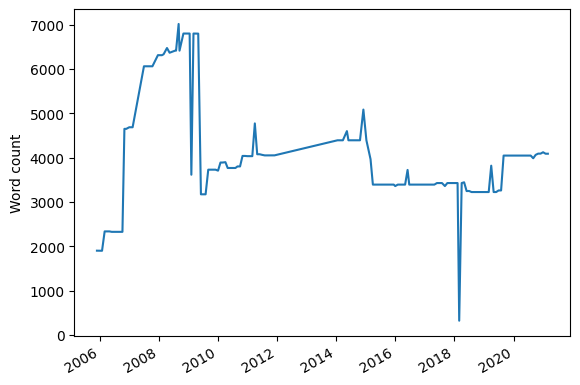

In [20]:
# Turn the dictionary into a pandas Series
fb_terms_s = pd.Series(fb_terms_wordcount2)

# Conver the index to datetime objects
fb_terms_s.index = pd.to_datetime(fb_terms_s.index)

# Plot
ax = fb_terms_s.plot()

# Make the x-tick labels less weird
# ax.set_xticklabels(range(2004,2021,2),rotation=0,horizontalalignment='center')

# Always label your axes
ax.set_ylabel('Word count');

## Scraping Wikipedia

Consider the Wikipedia page for [Elizabeth II](https://en.wikipedia.org/wiki/Elizabeth_II). This seems like a relatively straightforward webpage to scrape out the hyperlinks to other articles or to compare the content to other presidential biographies. However, Wikipedia also preserves the [history of every revision made to this article](https://en.wikipedia.org/w/index.php?title=Elizabeth_II&action=history) going back to the first (available) revisions in 2001, like [this](https://en.wikipedia.org/w/index.php?title=Elizabeth_II&oldid=249061). Thinking back to the Oscars example, it seems promising to find the "oldid" values and visit each revision's webpage to parse the content out. However, Wikipedia will give you much of this revision history data for free through its [application programming interface](http://en.wikipedia.org/w/api.php) (API).

### Current content
We can use `requests` to get the current HTML markup of an article from the API, for example.

In [21]:
# Where the API server lives
query_url = "https://en.wikipedia.org/w/api.php"

# An empty dictionary to store our query parameters
query_params = {}

# We want to parse the content of a page
query_params['action'] = 'parse'

# Which page?
query_params['page'] = 'Elizabeth II'

# We want the text
query_params['prop'] = 'text'

# Ignore the edit buttons and table of contents
query_params['disableeditsection'] = 1
query_params['disabletoc'] = 1

# Get the results back as JSON
query_params['format'] = 'json'

# Format the data in an easier-to-parse option
query_params['formatversion'] = 2

We have only set up our request to the API, but not sent it or received the data back.

In [22]:
json_response = requests.get(url = query_url, params = query_params).json()

What's waiting inside? A dictionary of dictionaries. The inner dictionary has keys for the title of the page we requested ("Elizabeth II"), the pageid (a numeric identifier), and the text of the article.

In [23]:
json_response['parse'].keys()

dict_keys(['title', 'pageid', 'text'])

We could count the number of links in the article.

In [24]:
ghwb_soup = BeautifulSoup(json_response['parse']['text'])

ghwb_soup.find_all('a')[:5]

[<a class="mw-disambig" href="/wiki/Elizabeth_II_(disambiguation)" title="Elizabeth II (disambiguation)">Elizabeth II (disambiguation)</a>,
 <a class="mw-redirect mw-disambig" href="/wiki/Elizabeth_of_the_United_Kingdom_(disambiguation)" title="Elizabeth of the United Kingdom (disambiguation)">Elizabeth of the United Kingdom (disambiguation)</a>,
 <a href="/wiki/Head_of_the_Commonwealth" title="Head of the Commonwealth">Head of the Commonwealth</a>,
 <a class="mw-file-description" href="/wiki/File:Queen_Elizabeth_II_official_portrait_for_1959_tour_(retouched)_(cropped)_(3-to-4_aspect_ratio).jpg"><img alt="Elizabeth facing right in a half-length portrait photograph" class="mw-file-element" data-file-height="985" data-file-width="739" decoding="async" height="333" src="//upload.wikimedia.org/wikipedia/commons/thumb/1/11/Queen_Elizabeth_II_official_portrait_for_1959_tour_%28retouched%29_%28cropped%29_%283-to-4_aspect_ratio%29.jpg/250px-Queen_Elizabeth_II_official_portrait_for_1959_tour_%2

Or the content of the article.

In [25]:
ghwb_soup.find_all('p')[:5]

[<p class="mw-empty-elt">
 </p>,
 <p><b>Elizabeth II</b> (Elizabeth Alexandra Mary; 21 April 1926 – 8 September 2022) was <a class="mw-redirect" href="/wiki/Queen_of_the_United_Kingdom" title="Queen of the United Kingdom">Queen of the United Kingdom</a> and other <a href="/wiki/Commonwealth_realm" title="Commonwealth realm">Commonwealth realms</a> from 6 February 1952 until <a href="/wiki/Death_and_state_funeral_of_Elizabeth_II" title="Death and state funeral of Elizabeth II">her death</a> in 2022. She had been <a href="/wiki/Queen_regnant" title="Queen regnant">queen regnant</a> of <a href="/wiki/List_of_sovereign_states_headed_by_Elizabeth_II" title="List of sovereign states headed by Elizabeth II">32 sovereign states</a> during her lifetime and was the monarch of 15 realms at her death. Her reign of 70 years and 214 days is the <a href="/wiki/List_of_monarchs_in_Britain_by_length_of_reign" title="List of monarchs in Britain by length of reign">longest of any British monarch</a>, the

### Revision history

There is also an API endpoint for the revision history of this article that contains metadata about the who and when of previous changes.

In [26]:
# Where the API server lives
query_url = "https://en.wikipedia.org/w/api.php"

# An empty dictionary to store our query parameters
query_params = {}

# We want to query properties of a page
query_params['action'] = 'query'

# Which page?
query_params['titles'] = 'Elizabeth II'

# We want the revisions
query_params['prop'] = 'revisions'

# In particular, we want the revision ids, users, comments, timestamps
query_params['rvprop'] = 'ids|userid|comment|timestamp|user|size|sha1'

# Get 500 revisions
query_params['rvlimit'] = 500

# Start old and go newer
query_params['rvdir'] = 'newer'
    
# Get the results back as JSON
query_params['format'] = 'json'

# Format the data in an easier-to-parse option
query_params['formatversion'] = 2

Make the request.

In [27]:
json_response = requests.get(url = query_url, params = query_params).json()

Inspect this `json_response`. This returns a dictionary with both "continue" and "query" keys. The continue indicates there are more than 500 revisions present in the article's history and provides an index for the next query to pick up from. The query contains the revision history we care about—buried a bit in a nested data structure of lists and dictionaries, but we eventually get to the "revisions" list of dictionaries with the revision histories.

In [28]:
revisions = json_response['query']['pages'][0]['revisions']
revisions[:3]

[{'revid': 249061,
  'parentid': 0,
  'user': '61.9.128.xxx',
  'anon': True,
  'userid': 0,
  'timestamp': '2001-11-16T03:24:33Z',
  'size': 780,
  'sha1': 'cc5c02a29b5990567cd26323ddd2d3886d14a8fc',
  'comment': "mention she's also head of state of several other commonwealth nations"},
 {'revid': 249062,
  'parentid': 249061,
  'user': 'Berek',
  'userid': 79,
  'timestamp': '2001-12-14T19:38:09Z',
  'size': 840,
  'sha1': '4d3c00474e85d92a90a4b5509230515c7b4ef84d',
  'comment': "Mentioned QE2's coronation - anyone know the exact date?"},
 {'revid': 249063,
  'parentid': 249062,
  'user': 'Paul Drye',
  'userid': 6,
  'timestamp': '2001-12-14T23:06:32Z',
  'size': 856,
  'sha1': '00775574260757f567eabbcb282f5cf9abb868e7',
  'comment': 'June 2nd, 1953'}]

Convert to a DataFrame.

In [29]:
rev_df = pd.DataFrame(revisions)
rev_df.head()

,revid,parentid,user,anon,userid,timestamp,size,sha1,comment
0,249061,0,61.9.128.xxx,True,0,2001-11-16T03:24:33Z,780,cc5c02a29b5990567cd26323ddd2d3886d14a8fc,mention she's also head of state of several ot...
1,249062,249061,Berek,NaN,79,2001-12-14T19:38:09Z,840,4d3c00474e85d92a90a4b5509230515c7b4ef84d,Mentioned QE2's coronation - anyone know the e...
2,249063,249062,Paul Drye,NaN,6,2001-12-14T23:06:32Z,856,00775574260757f567eabbcb282f5cf9abb868e7,"June 2nd, 1953"
3,19902,249063,Conversion script,NaN,1226483,2002-02-25T15:51:15Z,935,9e42502da98959d456a0cc6c65c61d76bfda9042,Automated conversion
4,19962,19902,62.253.64.7,True,0,2002-02-28T02:55:35Z,943,a90261cb092d27801923f3777d481d71b4299511,*


Plot out how the size of the article changed over the first 500 revisions.

(0.0, 500.0)

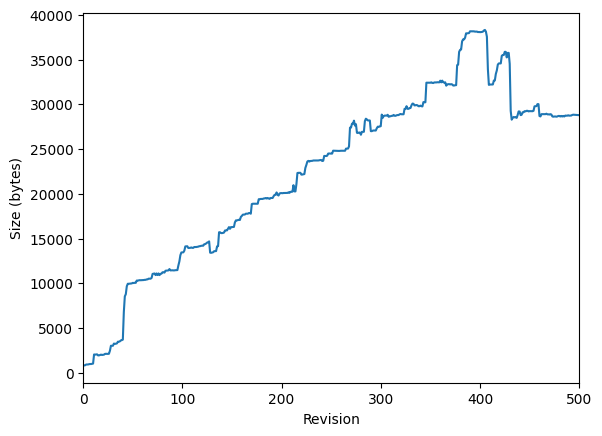

In [30]:
ax = rev_df.plot(y='size',legend=False)
ax.set_ylabel('Size (bytes)')
ax.set_xlabel('Revision')
ax.set_xlim((0,500))

Or count how many times an editor made a contribution.

In [31]:
rev_df['user'].value_counts().head()

user
Adam Carr      55
Jiang          33
Vzbs34         27
Jdforrester    15
82.43.55.44    14
Name: count, dtype: int64

### Pageview activity

There is are [API endpoints](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) for retrieving data on the number of times a Wikipedia article was accessed. Let's use the pageviews API ([docs](https://wikimedia.org/api/rest_v1/#/Pageviews data/)). Unfortunately, these article-level data are not stratifed by geography (by state, country, *etc*.) and are only available in the aggregate. This API only has data available back to July 2015, although there are some alternative [pageview definitions](https://meta.wikimedia.org/wiki/Research:Page_view) with data [available back to 2007](https://dumps.wikimedia.org/other/pagecounts-raw/). 

In [32]:
# This is the string for accessing the API with some variables we'll customize
pv_api_str = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{lang}.wikipedia/all-access/user/{article}/daily/{start}/{end}"

# Customizing the pv_api_str to get information about Elizabeth II from 1 July 2015 to 1 January 2023
retrieve_str = pv_api_str.format(
    lang = 'en',
    article = quote('Elizabeth II'),
    start = '20150701',
    end = '20240101'
)

# Make the request
pv_response = requests.get(retrieve_str,headers={'user-agent':'langholz@g.ucla.edu'}).json()

# Inspect
pv_response['items'][:5]

[{'project': 'en.wikipedia',
  'article': 'Elizabeth_II',
  'granularity': 'daily',
  'timestamp': '2015070100',
  'access': 'all-access',
  'agent': 'user',
  'views': 17717},
 {'project': 'en.wikipedia',
  'article': 'Elizabeth_II',
  'granularity': 'daily',
  'timestamp': '2015070200',
  'access': 'all-access',
  'agent': 'user',
  'views': 16529},
 {'project': 'en.wikipedia',
  'article': 'Elizabeth_II',
  'granularity': 'daily',
  'timestamp': '2015070300',
  'access': 'all-access',
  'agent': 'user',
  'views': 16534},
 {'project': 'en.wikipedia',
  'article': 'Elizabeth_II',
  'granularity': 'daily',
  'timestamp': '2015070400',
  'access': 'all-access',
  'agent': 'user',
  'views': 17353},
 {'project': 'en.wikipedia',
  'article': 'Elizabeth_II',
  'granularity': 'daily',
  'timestamp': '2015070500',
  'access': 'all-access',
  'agent': 'user',
  'views': 26460}]

Convert into a pandas `DataFrame` and cleanup.

In [ ]:
# Cast to a DataFrame
e2_pv_df = pd.DataFrame(pv_response['items'])

# Parse the "timestamp" column into a datetime
e2_pv_df['timestamp'] = pd.to_datetime(e2_pv_df['timestamp'],format='%Y%m%d%H')

# Set timestamp as index and only return reviews
e2_pv_s = e2_pv_df.set_index('timestamp')['views']

# Inspect
e2_pv_s.head()

Visualize on log-scaled y-axis.

In [ ]:
ax = e2_pv_s.plot()

ax.set_yscale('log')
ax.set_ylabel('Pageviews')
ax.set_ylim((1e4,1e7))

Write a function and use it in a loop to get the pageviews for each of these redirects.

In [33]:
def get_pageviews(article_title,lang='en',start='20150701',end='20250101',headers={'user-agent':'langholz@g.ucla.edu'}):
    # This is the string for accessing the API with some variables we'll customize
    _str = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{lang}.wikipedia/all-access/user/{article}/daily/{start}/{end}"

    # Customizing the pv_api_str to get information about Elizabeth II from 1 July 2015 to 1 January 2023
    _retrieve_str = _str.format(
        lang = lang,
        article = quote(article_title),
        start = start,
        end = end
    )
    
    # Make the request
    _response = requests.get(_retrieve_str,headers=headers).json()
    
    # Cast to a DataFrame
    _pv_df = pd.DataFrame(pv_response['items'])

    # Parse the "timestamp" column into a datetime
    _pv_df['timestamp'] = pd.to_datetime(_pv_df['timestamp'],format='%Y%m%d%H')

    # Set timestamp as index and only return reviews
    _pv_s = _pv_df.set_index('timestamp')['views']
    
    return _pv_s
    

Test the function.

<Axes: xlabel='timestamp'>

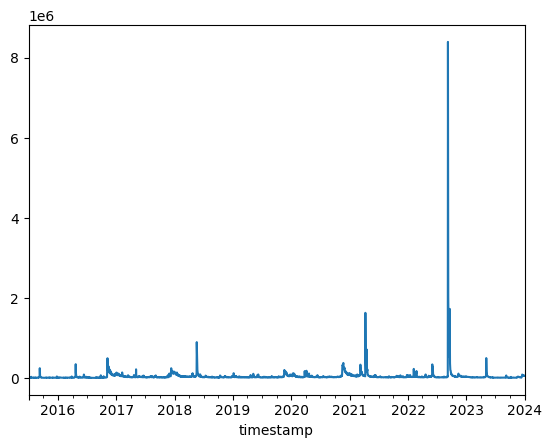

In [34]:
get_pageviews('University of California - Los Angeles').plot()

There are many other parts of the very powerful Wikipedia API and scraping these APIs exposes much more metadata than parsing the HTML of these webpages, while also being easier on the servers hosting it. 

Check out the "Class 04 - Wikipedia functions and analysis" notebook as well as my [`wikifunctions`](https://github.com/brianckeegan/wikifunctions/) library.